# Vision Language Models with Gemma 3

This notebook demonstrates how to use the Gemma3 Vision Language Model for various tasks, including text generation, image captioning, and answering questions about single or multiple images.

In [1]:
import contextlib
import random
from pathlib import Path
from typing import List, Union

import numpy as np
import torch
from PIL import Image
from IPython.display import display

from lxmls.multimodal.gemma3 import config
from lxmls.multimodal.gemma3 import model as gemma3_model

## Setup

First, let's define the arguments. You will need to set the `ckpt` path to your downloaded model checkpoint.

In [2]:
class Args:
    ckpt: str = "../../../data/gemma3/model.ckpt"
    device: str = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
    output_len: int = 128
    seed: int = 42
    quant: bool = False

args = Args()

In [3]:
# Helper functions

@contextlib.contextmanager
def _set_default_tensor_type(dtype: torch.dtype):
    torch.set_default_dtype(dtype)
    yield
    torch.set_default_dtype(torch.float)

def format_prompt(prompt_parts: List[Union[str, Image.Image]]):
    formatted_prompt = ["<start_of_turn>user\n"]
    formatted_prompt.extend(prompt_parts)
    formatted_prompt.append("<end_of_turn>\n<start_of_turn>model")
    return formatted_prompt

def truncate_model_output(text: str, clip_start: bool=False, clip_end: bool = True) -> str:
    if not (clip_start or clip_end):
        return text

    model_turn_marker: str = "<end_of_turn>\n<start_of_turn>model"
    try:
        start_index = text.index(model_turn_marker)
        if clip_end:
            search_start = start_index + len(model_turn_marker)
            end_index = text.index("<end_of_turn>", search_start)
        else:
            end_index = -1
        
        if not clip_start:
            search_start = 0
        return text[search_start:end_index]
    except ValueError:
        return text

def display_prompt_and_result(prompt, result, width=80):
    print("=" * width)
    print("INPUT")
    for part in prompt: 
        if isinstance(part, str):
            print(part, end="")
        elif isinstance(part, Image.Image):
            img_copy = part.copy()
            img_copy.thumbnail((256, 256))
            display(img_copy)
    print("\n", "-" * width)
    print("GENERATED")
    print(truncate_model_output(result))
    print("=" * width)

### Load Model and Images

In [4]:
# Get data dir from the checkpoint path
data_dir = Path(args.ckpt).parent

# Construct the model config
model_config = config.get_model_config()
model_config.dtype = "float32"
model_config.quant = args.quant
model_config.tokenizer = str(data_dir / "tokenizer.model")

# Reproducibility settings
random.seed(args.seed)
np.random.seed(args.seed)
torch.manual_seed(args.seed)

# Instantiate model and load weights
device = torch.device(args.device)
with _set_default_tensor_type(model_config.get_dtype()):
    model = gemma3_model.Gemma3ForMultimodalLM(model_config)
    model.load_state_dict(torch.load(args.ckpt)["model_state_dict"])
    model = model.to(device).eval()
print("Model loading done")

Model loading done


## Text-Only Generation

In [5]:
prompts = [
    format_prompt(["The capital of Italy is?"]),
]
results = model.generate(
    prompts,
    device,
    output_len=args.output_len,
)

for i, (prompt, result) in enumerate(zip(prompts, results)):
    display_prompt_and_result(prompt, result)

INPUT
<start_of_turn>user
The capital of Italy is?<end_of_turn>
<start_of_turn>model
 --------------------------------------------------------------------------------
GENERATED
<start_of_turn>user
The capital of Italy is?<end_of_turn>
<start_of_turn>model

The capital of Italy is **Rome**. 

It’s a historically and culturally significant city! 😊


## Generation with text & a single image as input

INPUT
<start_of_turn>user


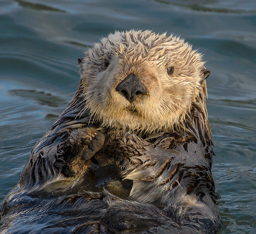

Caption this image.<end_of_turn>
<start_of_turn>model
 --------------------------------------------------------------------------------
GENERATED
<start_of_turn>user


<start_of_image><end_of_image>

Caption this image.<end_of_turn>
<start_of_turn>model
Here are a few captions for the image of the otter:

**Short & Sweet:**

*   "Just chilling."
*   "Otterly content."
*   "Zen otter."

**Funny:**

*   “Excuse me, do you have a moment to talk about seaweed?”
*   “I’m not judging, I’m just observing.”
*   “This is my ‘I’m fabulous’ pose.”

**Descriptive:**

*   "A peaceful moment with a California sea otter."
*   “Lost in thought, floating in the Pacific.”

**My


In [6]:
golden_test_image_path = data_dir / "images/test_image.jpg"
prompts = [
    format_prompt([ Image.open(golden_test_image_path), "Caption this image." ]),
]
results = model.generate(
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)

INPUT
<start_of_turn>user


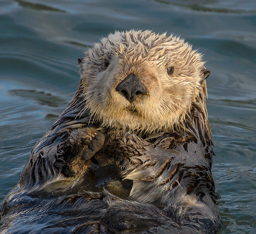

Caption this image.<end_of_turn>
<start_of_turn>model
 --------------------------------------------------------------------------------
GENERATED
<start_of_turn>user


<start_of_image><end_of_image>

Caption this image.<end_of_turn>
<start_of_turn>model
Here are a few captions for the image of the otter:

**Funny:**

* "Just contemplating my next snack."
* "Don't even *think* about disturbing my nap."
* "Existential otter."

**Cute & Descriptive:**

* “A perfect moment of otter bliss.”
* “This otter is taking a well-deserved rest.”
* “The face of pure relaxation.”

**A bit more thoughtful:**

* "Lost in the moment."
* “Finding peace on the water.”

---

Which one do you like best, or would you like me to generate some


In [7]:
cow_in_beach_path = data_dir / "images/cow_in_beach.jpg"
prompt = [
    format_prompt([ Image.open(cow_in_beach_path), "The name of the animal in the image is"]),
]
results = model.generate(
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)

## Generation with interleaved image & text input

INPUT
<start_of_turn>user
This image

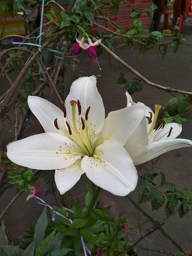

and this image

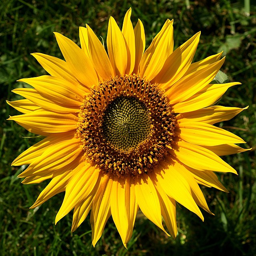

are similar because?<end_of_turn>
<start_of_turn>model
 --------------------------------------------------------------------------------
GENERATED
<start_of_turn>user
This image

<start_of_image><end_of_image>

and this image

<start_of_image><end_of_image>

are similar because?<end_of_turn>
<start_of_turn>model

Here's why the two images are similar:

*   **Color:** Both feature prominent shades of yellow and white. The lily has white petals with yellow stamens, and the sunflower is entirely yellow.
*   **Central Disc:** Both flowers have a central disc which is typically yellow/brown in color.
*   **Radial Symmetry:** Both exhibit radial symmetry, meaning they are arranged in a circular pattern.

Do you want to explore any specific similarities or differences between the flowers?


In [8]:
lilly_path = data_dir / "images/lilly.jpg"
sunflower_path = data_dir / "images/sunflower.JPG"
prompts = [
    format_prompt([
        "This image", Image.open(lilly_path),
        "and this image", Image.open(sunflower_path),
        "are similar because?"
    ]),
]
results = model.generate(
    prompts,
    device,
    output_len=args.output_len,
)

for prompt, result in zip(prompts, results):
    display_prompt_and_result(prompt, result)